# Protein unfolding: clustering of experimental data

In this notebook we will describe the analysis procedure based on K-means clustering which can be used to obtain information about conformational changes in the reaction of unfolding of protein molecules. 

This method can be also used to analyse data from other reactions involving polymer molecules. 

In [1]:
# Necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Motivation

Proteins are biomolecules that perform many critical functions in living organisms. A protein molecule is composed of a certain sequence of amino acids, which makes it fold into a specific 3D structure that determines the protein's activity.

The processes of protein folding and unfolding are fundamental biological events ,yet they are poorly understood by scientists.

Many proteins participate in biological processes that involve mechanical forces (e.g., muscle contraction, DNA replication,vesicle transportation).

Throughout these events, a protein molecule suffers mechanical perturbation: the mechanical force pulls on the protein and unfolds it. Different protein molecules exhibit different mechanical properties that determine the force magnitudes to which the proteins respond, a feature which is intimately connected to their function and is crucial for the processes they are involved in.

<div>
<img src="unfolding.png" alt="500" width="600"/>
</div>

The development of single molecule force spectroscopy techniques has enabled scientists to apply forces (of a piconewton (pN) magnitude) to unfold individual protein molecules. This kind of experiments can be used to characterise the energy landscape of protein folding and its response to mechanical stress, a biologically important stimulus.

In this project, I used a single molecule technique - magnetic tweezers - to apply different forces to individual protein molecules composed of different protein domains.

With magnetic tweezers technique, by moving the position of permanent magnets relative to a magnetic bead of a diameter of 2 micrometers, it is possible to apply force and iduce step-wise unfolding of individual domains in the tethered protein molecule. Likewise, by decreasing the applied force it is possible to induce refolding of previously unfolded protein domains.



<div>
<img src="set_up_2.png" alt="500" width="600"/>
</div>

In [2]:
# Load data into a dataframe
trace=pd.read_excel('trace.xlsx')

# Check the first few lows of the data
trace.head()

,time,length,force
0,32.2704,-2.57971,4.36977
1,32.2767,2.15869,4.36977
2,32.2829,-1.49097,4.36977
3,32.2892,0.81958,4.36977
4,32.2954,-2.87012,4.36977


A typical experimental data contains recordered data points stored in the following three columns:\
    
**time** is the number of seconds passed since the start of the recording;
    
**length** is the current length or extension of the molecule in nanometers;
    
**force** is the force in picoNewtons  with wchich the molecule is being pulled on. 


We can visualize how the length of the protein molecule changes with time during the course of the experiment
by plotting the length timeseries.

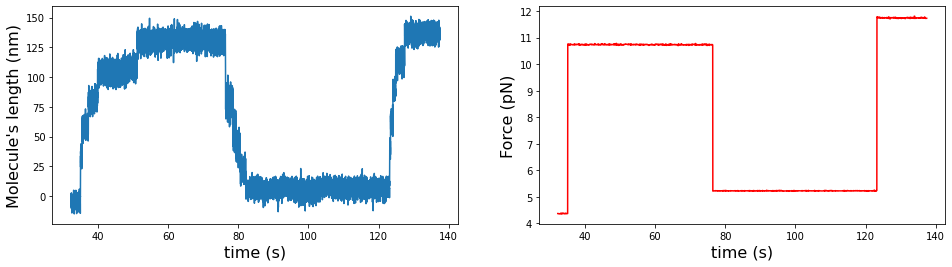

In [3]:
# Plot the protein length time series
f,ax=plt.subplots(1,2,figsize=(16,4))
ax[0].plot(trace['time'],trace['length'])
ax[0].set_ylabel("Molecule's length (nm)",fontsize=16)
ax[0].set_xlabel('time (s)',fontsize=16)
ax[1].plot(trace['time'],trace['force'],color='r')
ax[1].set_ylabel('Force (pN)',fontsize=16)
ax[1].set_xlabel('time (s)',fontsize=16)
plt.show()

In this experiment, we used a polyprotein molecule consisting of several identical domains joined in a chain.

When we pull on a protein molecule with a certain force, we can gradually unfold the polyprotein molecule domain by domain.

This is why we see different steps (or levels) of molecule's length - as we increase the force at wich we pull from 4.2 to 10.8
picoNewton (subplot on the right), the length of the molecule increases step by step till 140 nanometers (subplot on the left).
Every step here corresponds to an unfolding of one protein domain. 

When afterwards we decreased the force to low values (around time=75 seconds, subplot on the right), you can see the length 
steps again, but this time they are going down - the molecule length decreases. This step by step molecule length change 
corresponds to the gradual folding of the previously unfolded protein domains - each step corresponds to one domain.

Finally, when we increased the pulling force again at the time around 120 seconds (right subplot), you can see the
unfolding steps again (subplot on the left)

**Motivation:**
Oftentimes it is not easy to fully understand what kind of conformationbal changes the protein undergoes
throughout its unfolding/refolding trajectrories.

Data-mining techniques,like clustering, can provide us means to group and make sense of the information in the trajectory.

Let's first take a closer look at the part of the data when we unfolded the molecule for the first time.

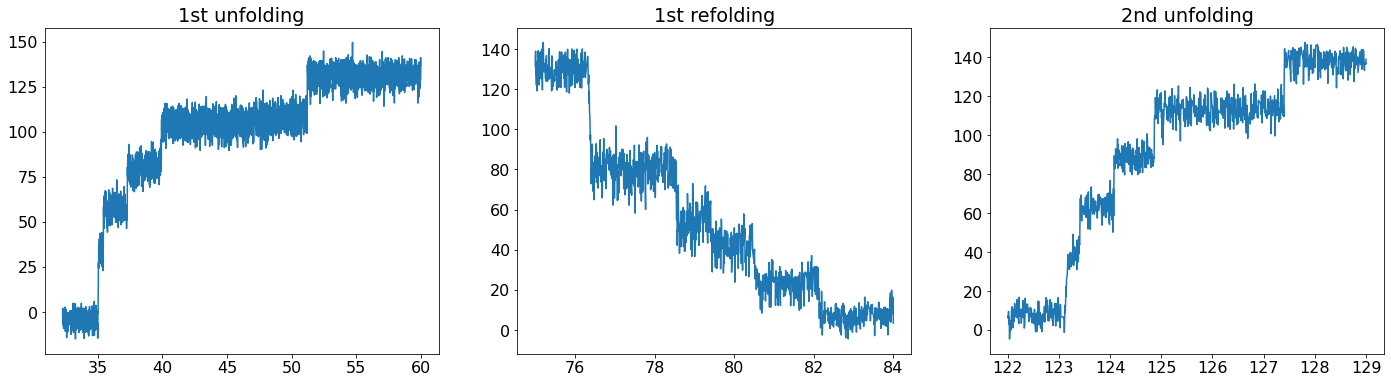

In [4]:
# Devide the trajectory into unfolding and refolding subtrajectories
unfold1=trace[(trace.time>30)&(trace.time<60)]
refold1=trace[(trace.time>75)&(trace.time<84)]
unfold2=trace[(trace.time>122)&(trace.time<129)]

# Plot subtrajectories
plt.figure(figsize=(24,6)) 
plt.rc('font', size=16)
plt.subplot(131)
plt.plot(unfold1['time'],unfold1['length'])
plt.title('1st unfolding')
plt.subplot(132)
plt.plot(refold1['time'],refold1['length'])
plt.title('1st refolding')
plt.subplot(133)
plt.plot(unfold2['time'],unfold2['length'])
plt.title('2nd unfolding')
plt.show()

You can notice that till the the second 35 the mollecule was completely folded - the length oscilated around 0 
nanometers.

Afterwards, there were 5 steps upstairs: one larger step from 0 to approximately 40 nm, followed by four more steps
of a similar size.

The first larger step here corresponds to the stretching of the molecule from a tangle to an extendeded form,and the four smaller step correspond to the unfolding of four identical protein domains joined into a chain.

We can see that, finally, when the fourd domains are unfold and the molecule is fully extended, its length reaches 
approximately 130 nm.

The goal of the analysis described in this notebook is to perform K-means clustering to identify the clusters in the molecule's
length data corresponding to different steps. As a results, we will be able to determine the length of each step, and thus,
we will gain the information about the size of the unfolding domains.



## K-means algorithm

The K-means algorithm begins with a first group of randomly selected centroids, which are used as the starting points for every cluster, and then the algorithm performs iterative calculations to optimize the positions of the centroids.

  **Centroid refinement algorithm:**


<div>
<img src="algorithm.png" alt="500" width="600"/>
</div>


Now, we will define three functions to perform K-means clustering of our data. The function **random_centroid** will select k number of random centroids for each of k clusters, the function **refine_centroids** will perform the steps of the centroid refinement 
algorithm, and the function **plot_clusters** will plot the obtained clusters in our data together with the clusters' optimized centoids.


### Define functions to implement k-means clustering

In [5]:
# Function that accepts the number of clusters (k) and selects random centroid for each cluster
def random_centroid(K,df):
    
    """This function accepts the number of 
    clusters and the the dataframe with
    the protein the legth over time
    and selects random centroids for each cluster"""
    
    #K-number of clusters
    # Select random observation as centroids
    random_centroids = (df.sample(n=K))
    random_centroids=random_centroids.reset_index()
    return random_centroids

In [6]:
# Function for the centroid refinement algorithm
def refine_centroids(K,df,centroids):
    
    """This function takes as an input the number of clusters (K),
    the data frame(df) and the coordinates of initial centroids(centroids)
    
    The function assings each data points to the closest centroid and recomputes centroids of newly formed clusters
    until they do not change"""
    
    dif = 1 #set difference not equal to 0
    
    while(dif!=0):   # We are stopping the training when the centroids are not changing any more.
        
        
        # 1.1 Calculate Euclidian distances from all df points to each centroid
        i=1 # first centroid
        for index_c,row_c in centroids.iterrows():
            
            ED=[] # initialize a list for Euclidian distances between points and current centroid
            
            # Calculate Euclidian distance(d) between a point and the current centroid
            for index_df,row_df in df.iterrows():
                d1=(row_c["time"]-row_df["time"])**2 
                d2=(row_c["length"]-row_df["length"])**2
                d=np.sqrt(d1+d2) 
                
                ED.append(d)
            df[i]=ED # Eclidican distances of all df instances(points) to the i centroid
            i=i+1 # move to the next centroid
   

        #1.2 Assign points to clusters according to their closest centoids
        cluster=[]
        for index,row in df.iterrows():
            min_dist=row[1]
            cl=1
            for i in range(K):
                 if row[i+1] < min_dist:
                        min_dist = row[i+1]
                        cl=i+1
            cluster.append(cl)
            
        df["Cluster"]=cluster
        
        # 2. Calculate new centroids of each cluster
        #new_centroids = df.groupby(["Cluster"]).mean()[["length","time"]]
        new_centroids = df.groupby(["Cluster"]).mean()[["length","time"]].reset_index()
        
        
        # 3. Difference between recalculated centroids and centroids from previous iteration
        dif = (new_centroids['length'] - centroids['length']).sum() + (new_centroids['time'] - centroids['time']).sum()
        print(dif)
            
        # Assign centroids_new from current iterration to centroids  
        centroids = df.groupby(["Cluster"]).mean()[["length","time"]].reset_index()
        
    return centroids # Final calculated centroids 

In [7]:
def plot_clusters(K,df, Centroids,title):
    color=['blue','green','cyan','black','orange','purple','grey']
    for k in range(K):
        data=df[df["Cluster"]==k+1]
        plt.scatter(data["time"],data["length"],c=color[k])
    plt.scatter(Centroids["time"],Centroids["length"],c='red')
    plt.title(title)
    plt.xlabel('time (s)')
    plt.ylabel('length (nm)')
    plt.show()

## Find clusters with K-means with random initial centroids

We know that the number of clusters in a subtrajectory should be 6 which include the following conformationanal states:

- completely folded protein;
- initial extention due to the elastic extension of the handles
- first domain unfolded;
- first + second domains unfolded;
- first + second + third domains unfolded;
- fully unfolded protein: firts + second + third + fourth domain unfolded.

In the case of refolding, the subtrajectroy will follow these same steps in the reversed direction.


Now  we will find clusters in the unfolding and refolding subtrajectories by providing random guesses for initial centroids
for K-means algorithm.

### Obtain coordinates of 6 random centroids for each subtrajectory

In [8]:
# Obtain coordinates of 6 random centroids for each subtrajectory
random_centroids_unf1=random_centroid(6,unfold1)
random_centroids_ref1=random_centroid(6,refold1)
random_centroids_unf2=random_centroid(6,unfold2)

### Optimize centroids

In [9]:
# Recompute the centroids according to the k-meands algorithm
centroids_unf1=refine_centroids(6,unfold1,random_centroids_unf1)
centroids_ref1=refine_centroids(6,refold1,random_centroids_ref1)
centroids_unf2=refine_centroids(6,unfold2,random_centroids_unf2)

-37.05753078783967
-10.49280729067749
-3.636499547609978
-2.929965003338378
-4.122439972969021
-5.812845093868344
-7.028433516943398
-9.756232274223205
-6.663768702273368
-2.9793978107373746
-0.658887516593353
-0.30436230330393244
-0.1276976487413748
-0.13071847580820872
-0.124164718949622
0.0
25.585641748572684
13.976889042983775
-0.6635192030623598
-1.8041250966356701
-1.8562879036049882
-1.8568433054270654
-1.241964230831904
-0.9324911383785981
-1.0134257081420301
-0.6103070741707839
-0.533560986597557
-0.16664797710652124
0.0
-4.309770934322595
1.793585292467597
3.043584121818828
3.0527684082832645
2.484346901478462
1.500845148616877
0.10204568604979691
-0.1500243724048147
-0.13081363968117898
-0.07640303235464785
-0.07753664494553902
-0.13170805342454628
-0.2621509430958895
-0.26597134352776663
-0.3685209632706119
-0.6295079112612996
-0.9067357662702875
-0.7244424651790098
-0.5979388668002343
-0.3174516111672574
-0.42477879896321724
-0.895252169736807
-1.2682890063246646
-1.547035

### Visualize clusters together with their centroids

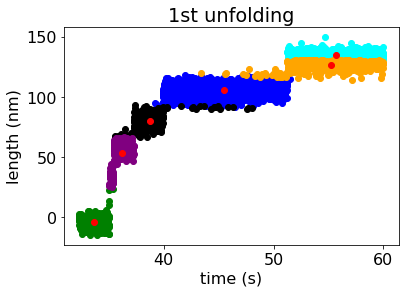

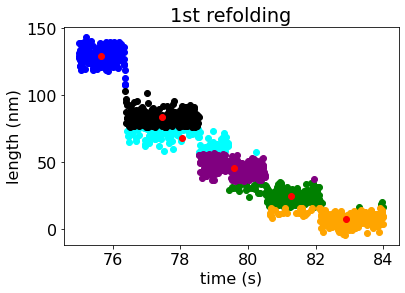

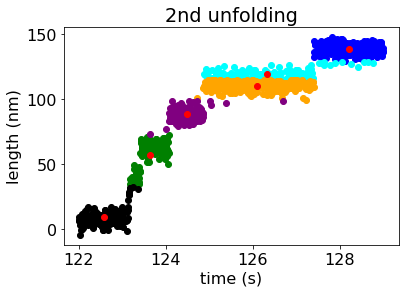

In [10]:
# Plot the obtained clusters together with the centroids
plot_clusters(6,unfold1,centroids_unf1,'1st unfolding')
plot_clusters(6,refold1,centroids_ref1,'1st refolding')
plot_clusters(6,unfold2,centroids_unf2,'2nd unfolding')

You can see that the algorithm with randomly preselected initial centroids could not correctly identify the clusters corresponding to the six steps of the reaction. 

For instance, in the case of the 1st unfolding subtrajectory, the algorithm unified the steps corresponding to the unfolding of the first two protein domains (the purple cluster contains the steps of the unfolding of two domains intead of just one), instead the
algorithm divided the second-last step into two clusters (the cyan and orange clusters).

## Find clusters with guessed initial centroids

In [11]:
#Assingn coordinates of initial centoids
time=[33,36,37,39,46,55]
length=[-4,26,56,80,105,130]
guess_centroids_unf1= pd.DataFrame(list(zip(time, length)),columns =['time', 'length'])

time=[75,77.5,79,81,81.3,83]
length=[130,80,55,42,23,3]
guess_centroids_ref1= pd.DataFrame(list(zip(time, length)),columns =['time', 'length'])

time=[122.5,123.3,124,124.8,126,128.5]
length=[9,40,63,90,115,138]
guess_centroids_unf2= pd.DataFrame(list(zip(time, length)),columns =['time', 'length'])

Now, that we assigend the coordinates for the initial cluster centroids, let's perform the steps **2** - **4** of the algorithm to find clusters in the unfolding/refolding subtrajectories once more.

In [12]:
# Recompute the centroids according to the k-meands algorithm
centroids_unf1=refine_centroids(6,unfold1,guess_centroids_unf1)
centroids_ref1=refine_centroids(6,refold1,guess_centroids_ref1)
centroids_unf2=refine_centroids(6,unfold2,guess_centroids_unf2)

8.057806753601065
2.064435672369364
0.23843202962048338
0.06802377513523084
0.0
4.114784773839279
2.5947733780202613
2.3860180480990074
1.812494754004776
1.7603127671230059
1.5829875141787477
1.5564505864799791
1.4987087094519964
1.3213303952813975
0.6282248957863956
0.5999465081757762
0.9270573746217181
0.6024694906875787
0.3930664360043963
0.585311675985448
0.38523934834279316
0.3835069891951619
0.17610937331524212
0.16412787296155784
0.08745087828273768
0.0839135930406627
0.0
-6.027790223168035
-0.6438434076819419
-0.13778244914362858
0.0


### Visualize new clusters

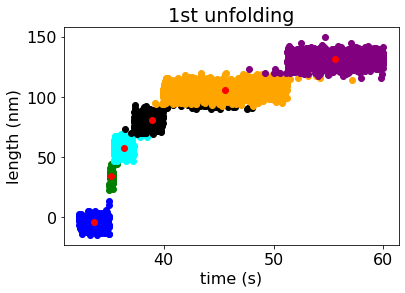

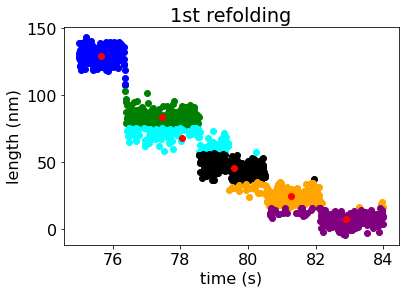

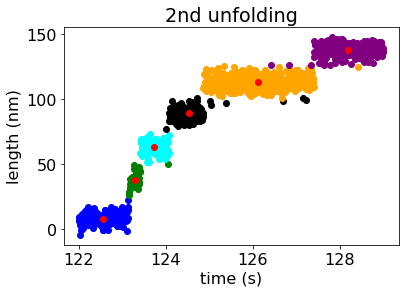

In [13]:
# Plot the obtained clusters together with the centroids
plot_clusters(6,unfold1,centroids_unf1,'1st unfolding')
plot_clusters(6,refold1,centroids_ref1,'1st refolding')
plot_clusters(6,unfold2,centroids_unf2,'2nd unfolding')

Wow, by assigning approximate initial coordinates of the centroids, the K-means algorithm was able to correctly define
the 6 clusters corresponding to different reaction steps for the two unfolding trajectories.
Unfortunately, we were not able to correctly capture conformational changes during refolding.

Let's look at the obtained centroid coordinates and estimate the sizes of each reaction step.

**When we calculate the distances between the length and time points we are not taking into account the magnitude of their values**

**We can try to improve the algorithm by scaling all the values to the same magnitude**

### Scale the length and time coordinates 

In [16]:
# scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
refold1_scaled = scaler.fit_transform(refold1[['time','length','force']])

In [17]:
# Conver np array into pandas data frame
refold_scaled=pd.DataFrame(refold1_scaled,columns=['time','length','force'])

In [18]:
# Scale the data fame with centroid we guessed in the previous step for the refolding trajectory
guess_centroids_ref1_scaled=pd.DataFrame(scaler.fit_transform(guess_centroids_ref1),columns=['time','length'])

In [19]:
# Refine the centroids using scaled data
centroids_ref1_scaled=refine_centroids(6,refold_scaled,guess_centroids_ref1_scaled)

-0.3388729049591855
-0.043583718782036485
-0.0029344817401460166
-0.0035139666429087613
-0.0038281253915096597
-0.005606110176931134
-0.004134794926773308
-0.00359436962014692
-0.002430301359129
-0.00353451193935439
-0.001863372675761782
-0.002164282118655103
-0.002266057822697759
-0.0020287743673888248
-0.0002592810719427019
-0.00021399012309242238
-4.450557318985693e-05
-0.001325308786862156
-0.0031535172883547236
-0.001338165837675584
-0.0017094485761307288
-0.0016434378050565884
-0.001600730115965343
-0.0016527104968039469
3.3376751826963424e-05
-2.169143071628632e-05
-0.0005333650462823469
-0.000685409426454564
0.0


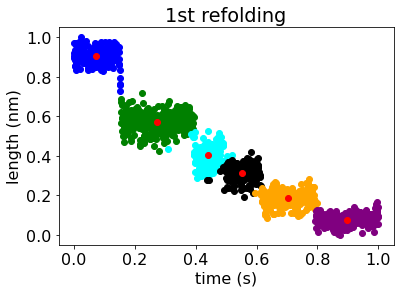

In [20]:
# Visualize obtained clasters
plot_clusters(6,refold_scaled,centroids_ref1_scaled,'1st refolding')

Voilà, now we obtained clusters that more correctly describe the conformational changes during protein refolding. 

## Extract domain sizes and conformational state lifetimes

With the information about the subtrajectories which we obtained with the clustering technique, we can extract
some interesting parameters characterizing protein folding and unfolding reactions:
    
- From the positions of the centroids, we can calculate a conformational change the protein undergoes during
  an unfolding trajectory,i.e. the initial extension of the molecule due to the increment of force will be the difference 
  between the length coordinates of the centroids of the cluster 2 and cluster 1.
- The difference between the length coordinates of the centroids of the cluster 3 and cluster 2 will be the extension of the 
  first unfolded domain.
- Likewise, the difference between the length coordinates of the centroids of the cluster 4 and cluster 3 will be the extension   of the second unfolded domain and so on.
- Additionally, we can calculate the lifetime of each conformation by calculating the diffrence between the maximum and minimum   value of the time coorinate within a corresponding cluster.  

In [21]:
# Updating centroids and cluster labels for refolding subtrajectory
refold1=refold1.reset_index(drop=True)
refold1['Cluster']=refold_scaled['Cluster']
centroids_ref1=refold1.groupby(["Cluster"]).mean()[["length","time"]].reset_index()

In [22]:
def extract_parameters(df,centroid):
    
    """This function extracts the following information from an input trajectrory:
    the cluster number, lifetime of each conformation,
     conformational change size and force. The function returns a data frame with this information"""
    
    cluster=[]
    life_time=[]
    conformational_change=[]
    force=[]
    
    for i in range(6):
        cluster.append(i+1)
        
        life_time.append(df[df['Cluster']==i+1].time.max()-df[df['Cluster']==i+1].time.min())
        if i==0:
            conformational_change.append(0)
        else:
            conformational_change.append(centroid.iloc[i,1]-centroid.iloc[i-1,1])
        force.append(np.round(df[df['Cluster']==i+1].force.mean()))
    parameters=pd.DataFrame({'cluster':cluster,'lifetime, s':life_time,'conformational_change, nm':conformational_change,'Force, pN':force})
    return parameters
    

In [23]:
parameters_unfold1=extract_parameters(unfold1,centroids_unf1)
parameters_unfold1

,cluster,"lifetime, s","conformational_change, nm","Force, pN"
0,1,2.7611,0.000000,4.0
1,2,0.7077,38.223231,10.0
2,3,3.0679,23.776119,11.0
3,4,11.5518,23.103829,11.0
4,5,17.9882,25.090085,11.0
5,6,12.2093,25.328464,11.0


In [24]:
parameters_unfold2=extract_parameters(unfold2,centroids_unf2)
parameters_unfold2

,cluster,"lifetime, s","conformational_change, nm","Force, pN"
0,1,1.139,0.000000,5.0
1,2,0.908,29.638826,10.0
2,3,0.658,25.473143,12.0
3,4,3.214,25.958906,12.0
4,5,3.556,24.233577,12.0
5,6,2.573,24.748173,12.0


## Conclusions

- **We applied K-means clustering technique to better understand protein folding and unfolding trajectories obtained in optical
  tweezers experiments.**
  
    We were able to extract information about conformational changes that that a protein molecule undergoes during 
    unfolding and refolding under application of different external forces. 
    
    E.g. we found out that in the unfolding reation at 10 pN, the protein gained an initial extension of 38 nm due to hanles    polymer extension,
    the two domains that unfolded first had an extension of 23 nm, and the next two domains had an extension of
    25 nm. 
    
    We were able to extract information about lifetimes of different conformations of the protein during its unfolding/ refolding reactions.
    
    E.g.we found out that in the unfolding reation at 10 pN, the lifetime of the conformation in which none of the domains was
    unfolded and only polymer handles were stretched, was around 0.71 s,the lifetime of the conformation with
    one of the domains of a size of 23 nm unfolded was around 3.1 s, the lifetime of the conformation with
    both domains of a size of 23 nm unfolded was around 3.1 s 11.6 seconds, and the lifetime of the conformation with
    one additional unfolded domain of a size of 25 nm was around 18 s.
    
    We can see that the lifetime of protein domains decreases with the increment of the force, since with higher force it is
    easier to break the intermolecular interactios inside the domain.